# Projet Deep Learning — Partie 4

## Analyse du Modèle Partie 2 avec Loss IoU

Ce notebook compare :
- **Modèle Partie 2 SANS IoU** (baseline)
- **Modèle Partie 2 AVEC IoU** (avec régularisation)

---

## 1. Configuration et imports

In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd


import config
from dataloader import get_dataloaders
from model_same_res import CrossViTSameResolution
from attention_rollout import (
    AttentionHook, attention_rollout, rollout_to_heatmap,
    compute_iou, visualize_attention
)

device = config.DEVICE
print(f"Device: {device}")

Device: cuda


c:\Users\Roméo\AppData\Local\Programs\Python\Python314\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Charger les deux modèles

### Modèle 1 : Partie 2 SANS IoU (baseline)

In [2]:

checkpoint_baseline = "checkpoints/part2_same_res_best.pth"

model_baseline = CrossViTSameResolution(
    img_size=224,
    patch_size=16,
    num_classes=2,
    embed_dim=256,
    depth=4,
    num_heads=8
)
model_baseline = model_baseline.to(device)

if os.path.exists(checkpoint_baseline):
    checkpoint = torch.load(checkpoint_baseline, map_location=device)
    model_baseline.load_state_dict(checkpoint["model_state_dict"])
    print(f"✅ Modèle baseline chargé depuis {checkpoint_baseline}")
    print(f"   Val F1: {checkpoint.get('val_f1', '?'):.4f}")
else:
    print(f"⚠️  Checkpoint baseline non trouvé")
    print("   Entraîner avec: python train.py --part 2 --epochs 1")

model_baseline.eval()

✅ Modèle baseline chargé depuis checkpoints/part2_same_res_best.pth
   Val F1: 0.7982


CrossViTSameResolution(
  (patch_embed_1): PatchEmbed(
    (proj): Conv2d(3, 256, kernel_size=(16, 16), stride=(16, 16))
  )
  (patch_embed_2): PatchEmbed(
    (proj): Conv2d(3, 256, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks_1): ModuleList(
    (0): Block(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=256, out_features=768, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1024, out_features=256, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      

### Modèle 2 : Partie 2 AVEC IoU

In [3]:

checkpoint_iou = "checkpoints/part2_same_res_iou_best.pth"

model_iou = CrossViTSameResolution(
    img_size=224,
    patch_size=16,
    num_classes=2,
    embed_dim=256,
    depth=4,
    num_heads=8
)
model_iou = model_iou.to(device)

if os.path.exists(checkpoint_iou):
    checkpoint = torch.load(checkpoint_iou, map_location=device)
    model_iou.load_state_dict(checkpoint["model_state_dict"])
    print(f" Modèle avec IoU chargé depuis {checkpoint_iou}")
    print(f"   Val F1: {checkpoint.get('val_f1', '?'):.4f}")
else:
    print(f"⚠️  Checkpoint avec IoU non trouvé")
    print("   Entraîner avec: python train.py --part 2 --use-iou-loss --epochs 20")

model_iou.eval()

 Modèle avec IoU chargé depuis checkpoints/part2_same_res_iou_best.pth
   Val F1: 0.8241


CrossViTSameResolution(
  (patch_embed_1): PatchEmbed(
    (proj): Conv2d(3, 256, kernel_size=(16, 16), stride=(16, 16))
  )
  (patch_embed_2): PatchEmbed(
    (proj): Conv2d(3, 256, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks_1): ModuleList(
    (0): Block(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=256, out_features=768, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1024, out_features=256, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      

## 3. Préparer les données

In [4]:
train_loader, val_loader = get_dataloaders(img_size=224, batch_size=8)
print(f"Dataset chargé: {len(val_loader.dataset)} images de validation")

Dataset : 898 images | Train : 718 | Val : 180
Dataset chargé: 180 images de validation


## 4. Fonction de génération de heatmap

In [5]:
def generate_heatmap_for_sample(model, batch, device, patch_size=16):
    """
    Génère la heatmap pour un batch donné.
    
    Returns:
        heatmaps : (B, H, W) tensor
        logits : (B, num_classes) tensor
    """
    
    hook = AttentionHook()
    hook.register(model)
    
    
    original = batch["original"].to(device)
    segmented = batch["segmented"].to(device)
    
    with torch.no_grad():
        logits = model(original, segmented)
    
   
    cls_attn = attention_rollout(hook.attention_maps)
    
  
    heatmap = rollout_to_heatmap(cls_attn, img_size=224, patch_size=patch_size)
    
   
    hook.remove()
    
    return heatmap, logits

print(" Fonction de génération de heatmap prête")

 Fonction de génération de heatmap prête


## 5. Comparaison : Heatmaps SANS vs AVEC IoU

On va afficher côte à côte les heatmaps des deux modèles pour voir l'amélioration.

In [6]:

import random

n_samples = 4
all_samples = []


with torch.no_grad():
    for batch in val_loader:
        heatmap_baseline, logits_baseline = generate_heatmap_for_sample(model_baseline, batch, device)
        heatmap_iou, logits_iou = generate_heatmap_for_sample(model_iou, batch, device)
        
        preds_baseline = torch.argmax(logits_baseline, dim=1)
        preds_iou = torch.argmax(logits_iou, dim=1)
        
        original = batch["original"]
        mask = batch["mask"]
        labels = batch["label"]
        codes = batch["code"]
        
        for i in range(original.shape[0]):
            iou_baseline = compute_iou(heatmap_baseline[i].cpu(), mask[i].cpu())
            iou_iou = compute_iou(heatmap_iou[i].cpu(), mask[i].cpu())
            
            all_samples.append({
                "code": codes[i],
                "image": original[i].cpu(),
                "heatmap_baseline": heatmap_baseline[i].cpu(),
                "heatmap_iou": heatmap_iou[i].cpu(),
                "mask": mask[i].cpu(),
                "label": labels[i].item(),
                "pred_baseline": preds_baseline[i].item(),
                "pred_iou": preds_iou[i].item(),
                "iou_baseline": iou_baseline.item(),
                "iou_iou": iou_iou.item(),
            })


samples = random.sample(all_samples, n_samples)
print(f"{n_samples} échantillons aléatoires sélectionnés (sur {len(all_samples)} images)")

4 échantillons aléatoires sélectionnés (sur 180 images)


 Comparaison sauvegardée: results/part4_comparison_baseline_vs_iou.png


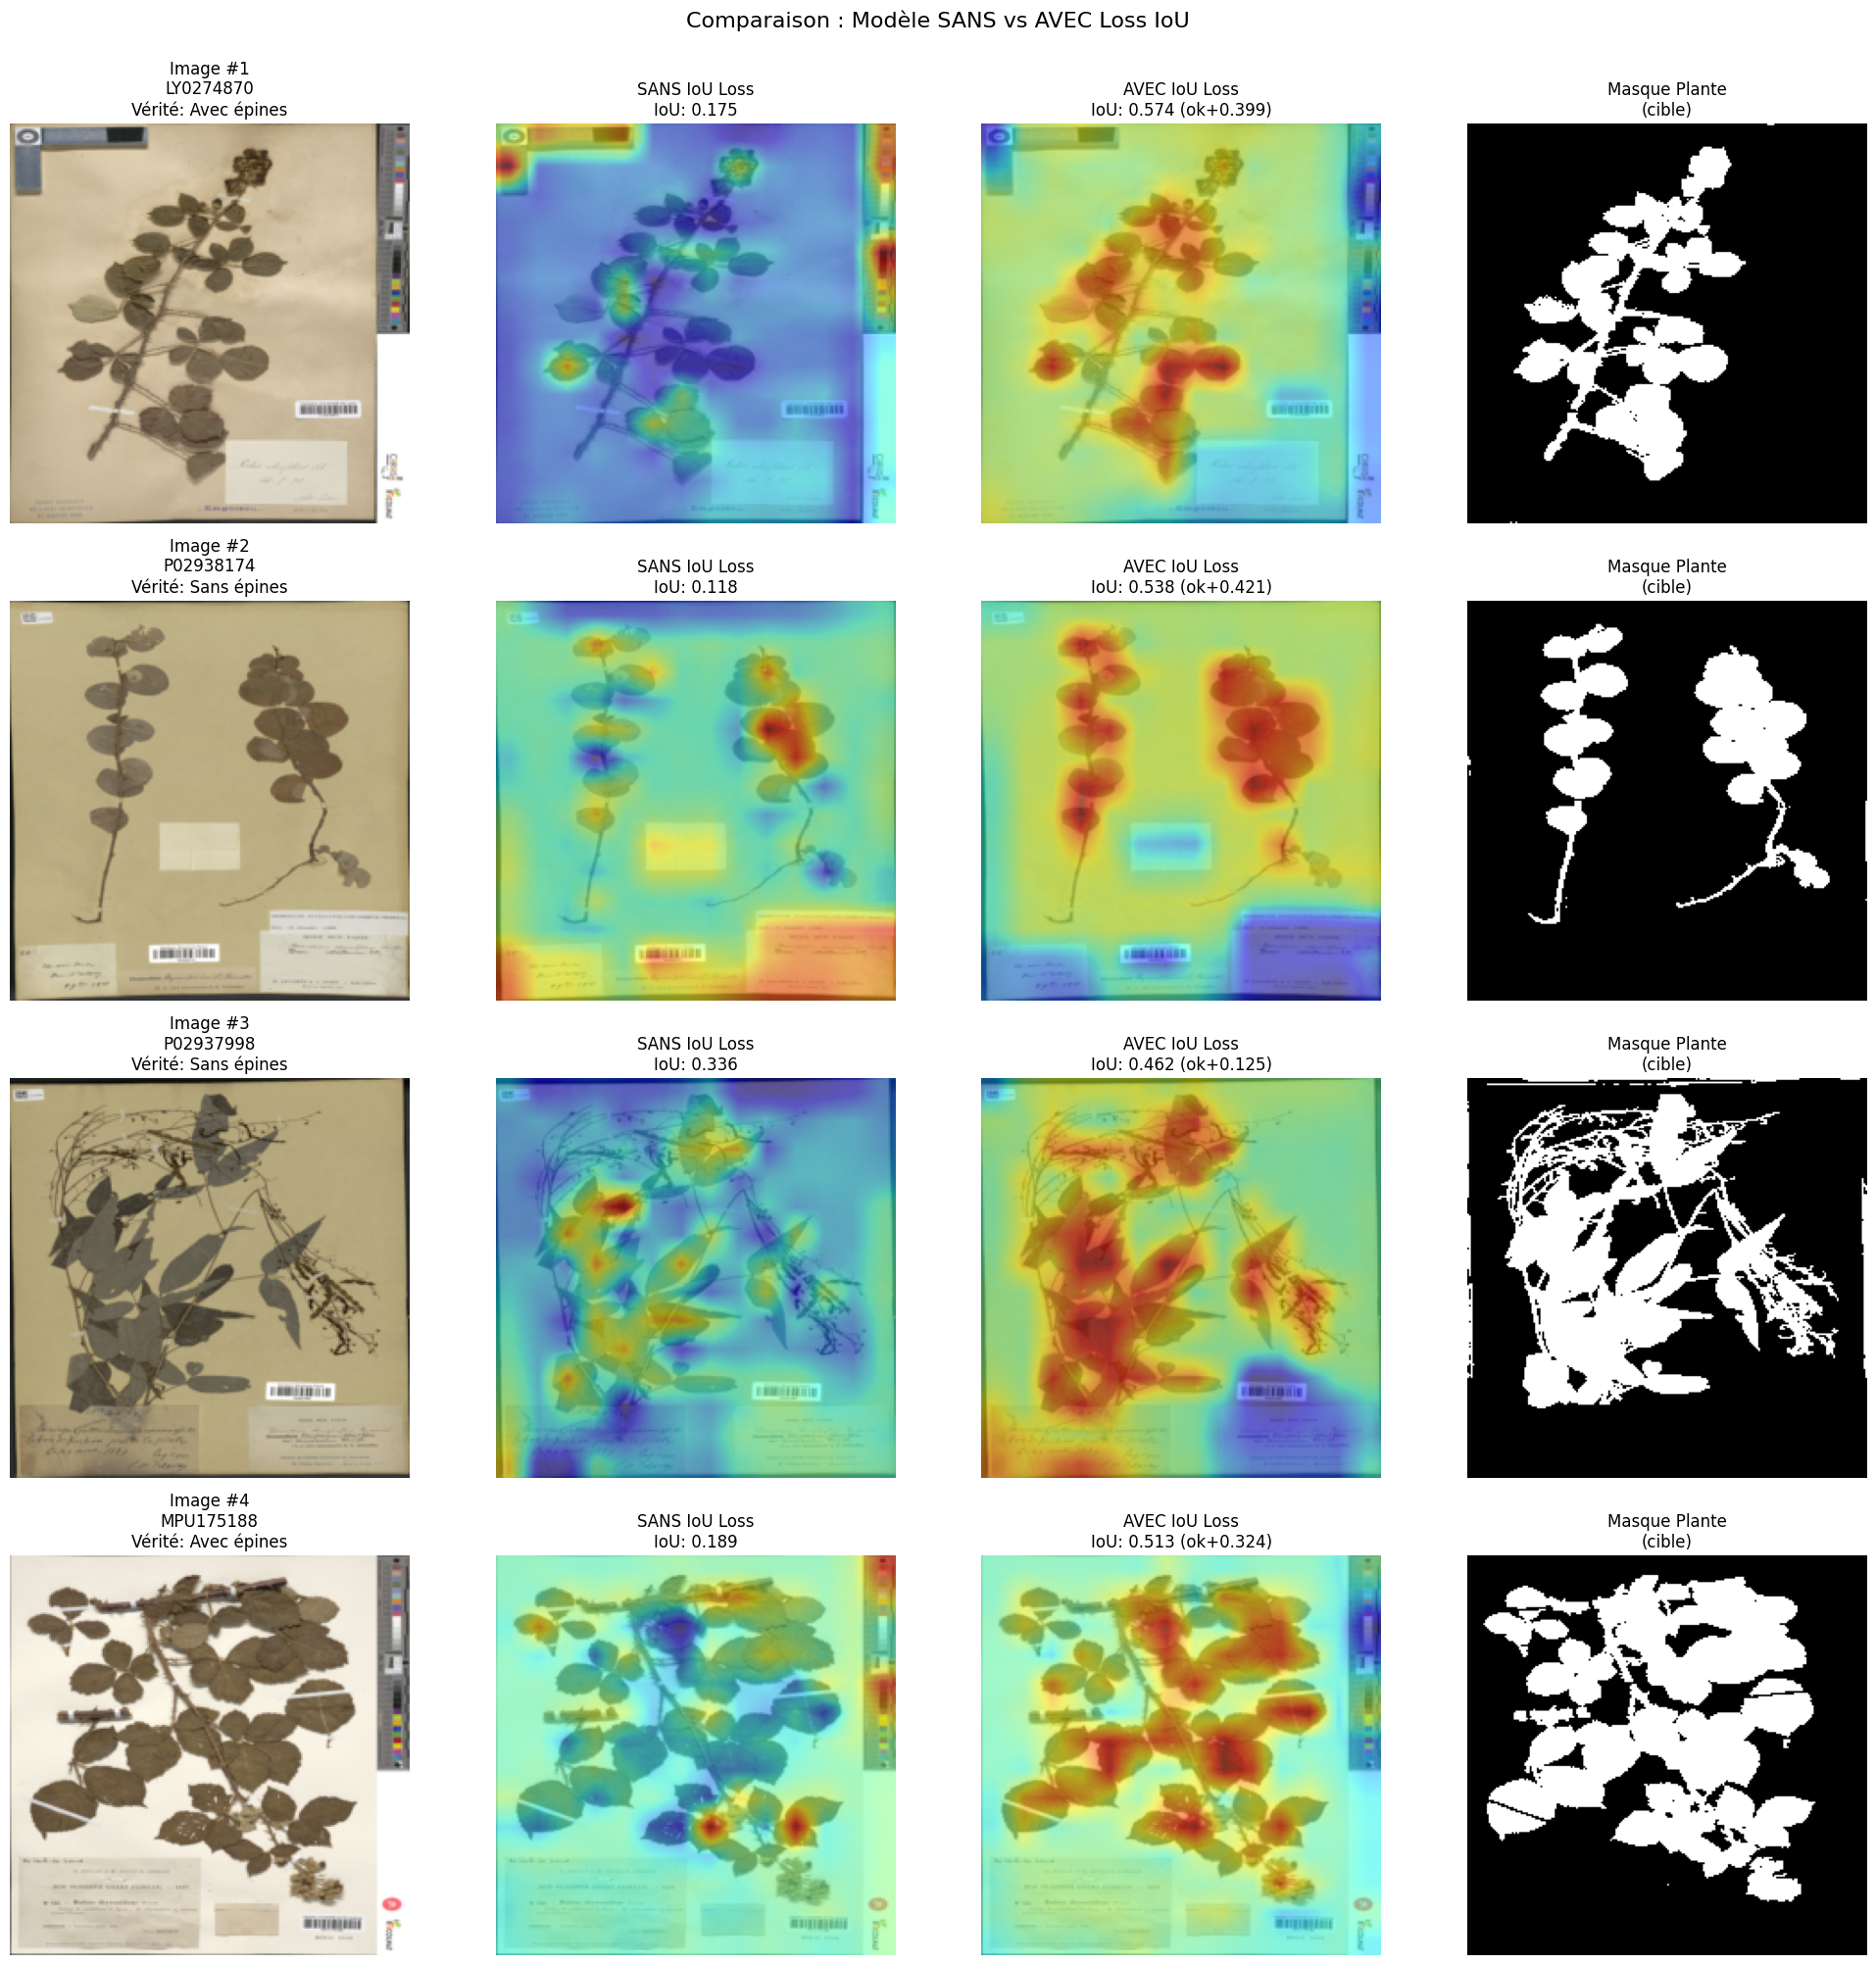

In [7]:

fig, axes = plt.subplots(n_samples, 4, figsize=(20, 5 * n_samples))

for idx, sample in enumerate(samples):
   
    mean = torch.tensor(config.IMAGENET_MEAN).view(3, 1, 1)
    std = torch.tensor(config.IMAGENET_STD).view(3, 1, 1)
    img = sample["image"] * std + mean
    img = img.clamp(0, 1).permute(1, 2, 0).numpy()
    
    heatmap_baseline = sample["heatmap_baseline"].numpy()
    heatmap_iou = sample["heatmap_iou"].numpy()
    mask = sample["mask"].squeeze().numpy()
    
    label_str = "Avec épines" if sample["label"] == 1 else "Sans épines"
    
 
    axes[idx, 0].imshow(img)
    axes[idx, 0].set_title(f"Image #{idx+1}\n{sample['code']}\nVérité: {label_str}")
    axes[idx, 0].axis("off")
    
  
    axes[idx, 1].imshow(img)
    axes[idx, 1].imshow(heatmap_baseline, cmap="jet", alpha=0.5)
    axes[idx, 1].set_title(f"SANS IoU Loss\nIoU: {sample['iou_baseline']:.3f}")
    axes[idx, 1].axis("off")
    
 
    axes[idx, 2].imshow(img)
    axes[idx, 2].imshow(heatmap_iou, cmap="jet", alpha=0.5)
    improvement = sample['iou_iou'] - sample['iou_baseline']
    sign = "ok" if improvement > 0 else "pas bon"
    axes[idx, 2].set_title(f"AVEC IoU Loss\nIoU: {sample['iou_iou']:.3f} ({sign}{improvement:+.3f})")
    axes[idx, 2].axis("off")
    
  
    axes[idx, 3].imshow(mask, cmap="gray")
    axes[idx, 3].set_title("Masque Plante\n(cible)")
    axes[idx, 3].axis("off")

plt.suptitle("Comparaison : Modèle SANS vs AVEC Loss IoU", fontsize=16, y=1.0)
plt.tight_layout()
plt.savefig("results/part4_comparison_baseline_vs_iou.png", dpi=150, bbox_inches="tight")
print(" Comparaison sauvegardée: results/part4_comparison_baseline_vs_iou.png")
plt.show()

## 6. Statistiques IoU : SANS vs AVEC

In [8]:
# Calculer IoU pour tout le dataset de validation
all_iou_baseline = []
all_iou_with_loss = []

print("Calcul des IoU sur tout le dataset de validation...")

with torch.no_grad():
    for batch in tqdm(val_loader, desc="IoU computation"):
        # Générer heatmaps
        heatmap_baseline, _ = generate_heatmap_for_sample(model_baseline, batch, device)
        heatmap_iou, _ = generate_heatmap_for_sample(model_iou, batch, device)
        
        mask = batch["mask"]
        
        for i in range(heatmap_baseline.shape[0]):
            iou_b = compute_iou(heatmap_baseline[i].cpu(), mask[i].cpu())
            iou_i = compute_iou(heatmap_iou[i].cpu(), mask[i].cpu())
            
            all_iou_baseline.append(iou_b.item())
            all_iou_with_loss.append(iou_i.item())

print(f"\n Calcul terminé pour {len(all_iou_baseline)} images")

Calcul des IoU sur tout le dataset de validation...


IoU computation: 100%|██████████| 23/23 [01:19<00:00,  3.47s/it]


 Calcul terminé pour 180 images


In [9]:
# Statistiques comparatives
print("\n" + "="*70)
print("COMPARAISON IoU : SANS vs AVEC Loss IoU")
print("="*70)

print(f"\n Modèle SANS IoU Loss (baseline):")
print(f"   Moyenne: {np.mean(all_iou_baseline):.4f}")
print(f"   Médiane: {np.median(all_iou_baseline):.4f}")
print(f"   Écart-type: {np.std(all_iou_baseline):.4f}")

print(f"\n Modèle AVEC IoU Loss:")
print(f"   Moyenne: {np.mean(all_iou_with_loss):.4f}")
print(f"   Médiane: {np.median(all_iou_with_loss):.4f}")
print(f"   Écart-type: {np.std(all_iou_with_loss):.4f}")

improvement = np.mean(all_iou_with_loss) - np.mean(all_iou_baseline)
improvement_pct = (improvement / np.mean(all_iou_baseline)) * 100

print(f"\n Amélioration:")
print(f"   Différence absolue: {improvement:+.4f}")
print(f"   Amélioration relative: {improvement_pct:+.1f}%")

if improvement > 0.1:
    print(f"    Amélioration SIGNIFICATIVE !")
elif improvement > 0.05:
    print(f"     Amélioration modérée")
else:
    print(f"   Amélioration faible ou nulle")

print("="*70)


COMPARAISON IoU : SANS vs AVEC Loss IoU

 Modèle SANS IoU Loss (baseline):
   Moyenne: 0.1919
   Médiane: 0.1446
   Écart-type: 0.1673

 Modèle AVEC IoU Loss:
   Moyenne: 0.5061
   Médiane: 0.5239
   Écart-type: 0.1330

 Amélioration:
   Différence absolue: +0.3143
   Amélioration relative: +163.8%
    Amélioration SIGNIFICATIVE !


C:\Users\Roméo\AppData\Local\Temp\ipykernel_30292\382065092.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([all_iou_baseline, all_iou_with_loss], labels=["SANS IoU", "AVEC IoU"])


 Distribution sauvegardée: results/part4_iou_comparison_distribution.png


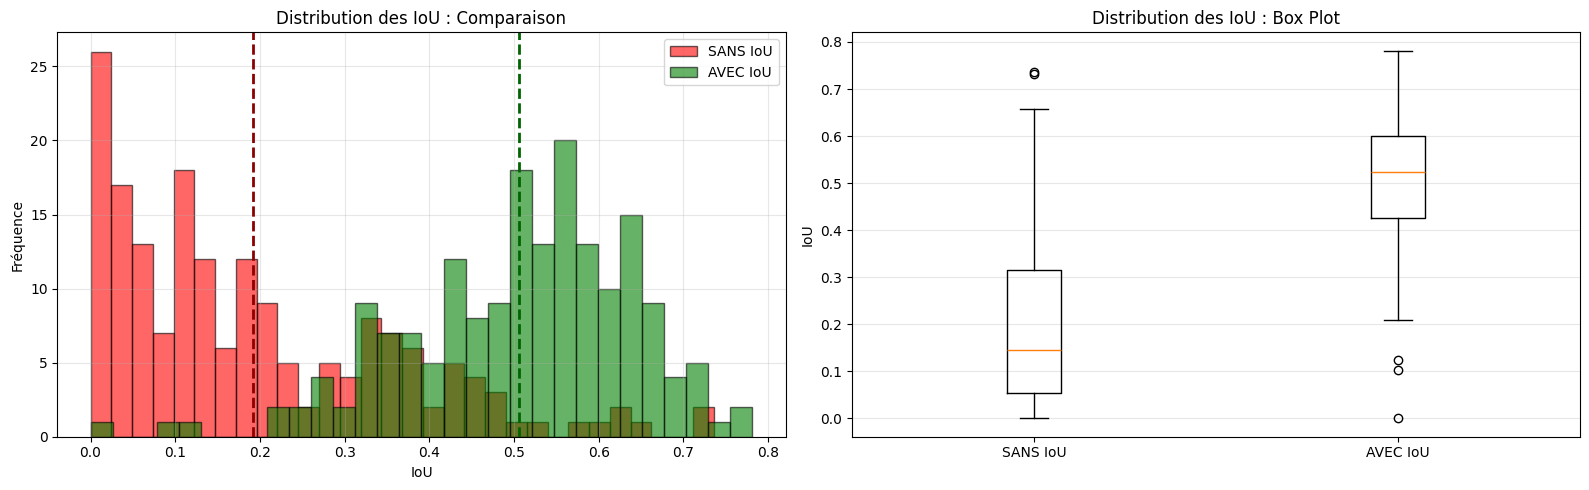

In [10]:

fig, axes = plt.subplots(1, 2, figsize=(16, 5))


axes[0].hist(all_iou_baseline, bins=30, alpha=0.6, color="red", label="SANS IoU", edgecolor="black")
axes[0].hist(all_iou_with_loss, bins=30, alpha=0.6, color="green", label="AVEC IoU", edgecolor="black")
axes[0].axvline(np.mean(all_iou_baseline), color="darkred", linestyle="--", linewidth=2)
axes[0].axvline(np.mean(all_iou_with_loss), color="darkgreen", linestyle="--", linewidth=2)
axes[0].set_xlabel("IoU")
axes[0].set_ylabel("Fréquence")
axes[0].set_title("Distribution des IoU : Comparaison")
axes[0].legend()
axes[0].grid(alpha=0.3)


axes[1].boxplot([all_iou_baseline, all_iou_with_loss], labels=["SANS IoU", "AVEC IoU"])
axes[1].set_ylabel("IoU")
axes[1].set_title("Distribution des IoU : Box Plot")
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig("results/part4_iou_comparison_distribution.png", dpi=150, bbox_inches="tight")
print(" Distribution sauvegardée: results/part4_iou_comparison_distribution.png")
plt.show()